### Imports

In [16]:
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
import numpy as np
import random
from qiskit.circuit.library import QAOAAnsatz
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.optimize import minimize

### Setting parameters

In [17]:
N = 2 # Number of doctors
M = 3 # Number of patients
W = [random.randint(5,30) for _ in range(M)]
k = 1000 # penalty parameter

### Creating QUBO formula

In [20]:
model = Model()
decision = model.binary_var_matrix(N, M, name="x")
# 
# subsums = [model.sum(decision[i,l]*W[l] for l in range(M)) for i in range(N)]
# main_obj = model.max(model.sum(subsums))
main_obj = model.max([model.sum(decision[i,l]*W[l] for l in range(M)) for i in range(N)])

i = 0
print(main_obj)
st_kara = (k/N)*model.sum((1-model.sum(decision[i,j] for i in range(N)))**2 for j in range(M))


model.minimize(main_obj+st_kara)
print(model.export_as_lp_string())
model = from_docplex_mp(model)
hamiltonian, offset = model.to_ising()

print(hamiltonian)

ansatz = QAOAAnsatz(hamiltonian, reps=2)

max(18x_0_0+16x_0_1+23x_0_2,18x_1_0+16x_1_1+23x_1_2)
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model12

Minimize
 obj: - 1000 x_0_0 - 1000 x_0_1 - 1000 x_0_2 - 1000 x_1_0 - 1000 x_1_1
      - 1000 x_1_2 + x9 + [ 1000 x_0_0^2 + 2000 x_0_0*x_1_0 + 1000 x_0_1^2
      + 2000 x_0_1*x_1_1 + 1000 x_0_2^2 + 2000 x_0_2*x_1_2 + 1000 x_1_0^2
      + 1000 x_1_1^2 + 1000 x_1_2^2 ]/2 + 1500
Subject To
 c1: x7 - 18 x_0_0 - 16 x_0_1 - 23 x_0_2 = 0
 c2: x8 - 18 x_1_0 - 16 x_1_1 - 23 x_1_2 = 0
 c3: x9 - x7 >= 0
 c4: x9 - x8 >= 0
 c5: x10 + x11 = 1
 lc1: x10 = 1 -> x9 - x7 <= 0
 lc2: x11 = 1 -> x9 - x8 <= 0

Bounds
 0 <= x_0_0 <= 1
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_1 <= 1
 0 <= x_1_2 <= 1
       x7 Free
       x8 Free
       x9 Free
 0 <= x10 <= 1
 0 <= x11 <= 1

Binaries
 x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x10 x11
End


KeyError: 'x8'

In [71]:
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model13

Minimize
 obj: - 980 x_0_0 - 984 x_0_1 - 988 x_0_2 - 980 x_1_0 - 984 x_1_1 - 988 x_1_2 +
      [ 1000 x_0_0^2 + 2000 x_0_0*x_1_0 + 1000 x_0_1^2 + 2000 x_0_1*x_1_1
      + 1000 x_0_2^2 + 2000 x_0_2*x_1_2 + 1000 x_1_0^2 + 1000 x_1_1^2
      + 1000 x_1_2^2 ]/2 + 1500
Subject To

Bounds
 0 <= x_0_0 <= 1
 0 <= x_0_1 <= 1
 0 <= x_0_2 <= 1
 0 <= x_1_0 <= 1
 0 <= x_1_1 <= 1
 0 <= x_1_2 <= 1

Binaries
 x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2
End


# QUANTUM MACHINE

In [72]:
service = QiskitRuntimeService(channel="ibm_quantum",token="f94ac321cc1f3d4cdf4405497462612138aaf73f98fdd3b2f0bd5b763173925667a63bfee29a9f1314ca9901e26f3137b4f37df5f1ace14a1447312c12da7930")

In [73]:
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

In [74]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]
    return cost

In [75]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIZIIIIIIIIIIIII

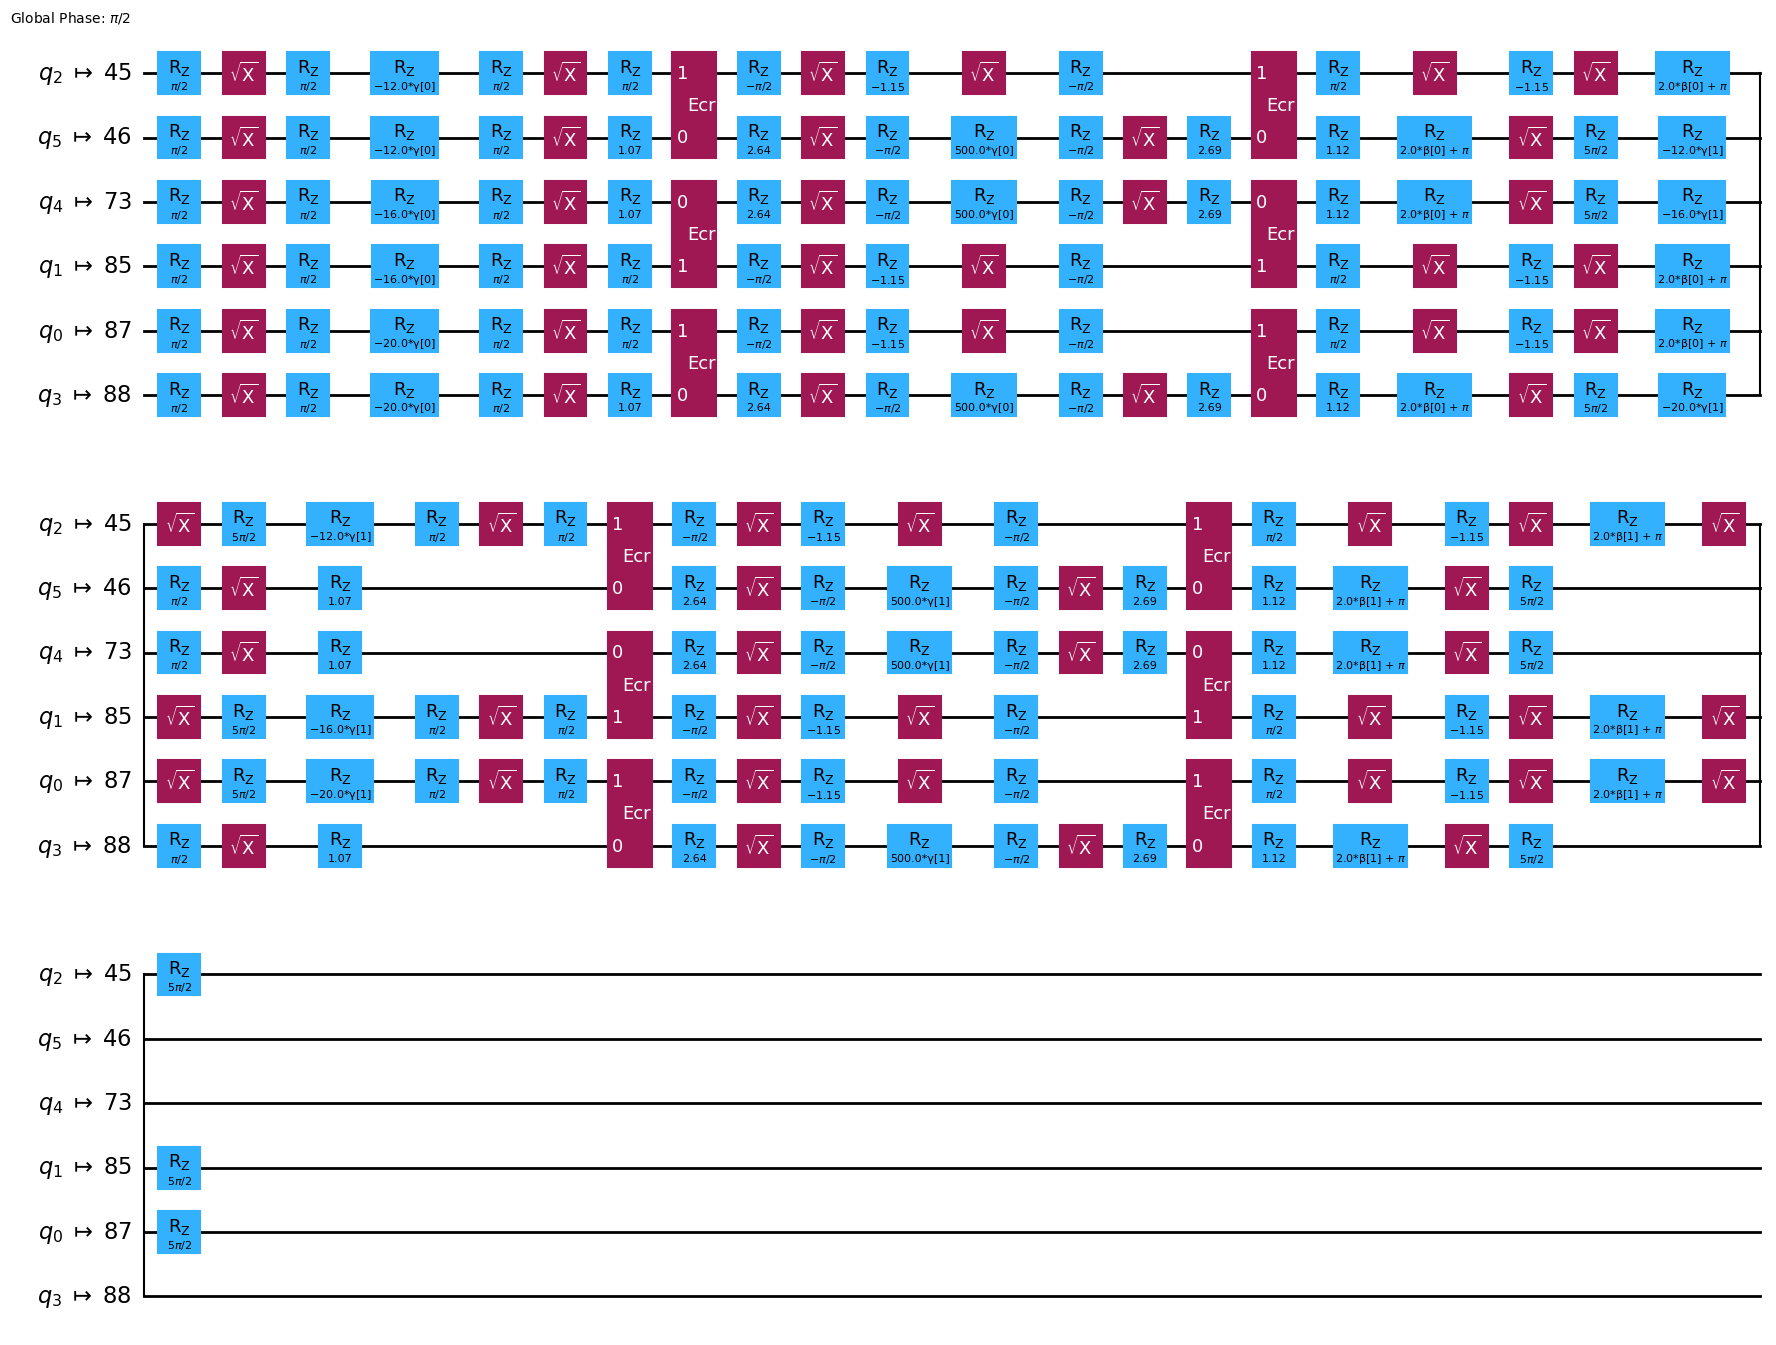

In [76]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [77]:
session = Session(backend=backend)

estimator = Estimator(session=session)
estimator.options.default_shots = 3_000
estimator.options.dynamical_decoupling.enable = True

sampler = Sampler(session=session)
sampler.options.default_shots = 3_000
sampler.options.dynamical_decoupling.enable = True

In [78]:
x0 = np.random.randint(2,size = ansatz_isa.num_parameters)
print(x0)

[0 0 1 0]


In [80]:
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA", options={"maxiter": 5, "display": True})

/home/kobala/kawntowemirki/venv/lib/python3.11/site-packages/scipy/optimize/_minimize.py:719: OptimizeWarning: Unknown solver options: display
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [ ]:
res

In [ ]:
qc = ansatz.assign_parameters(res.x)
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
session.close()

In [ ]:
plot_distribution(samp_dist, figsize=(15, 5))